C:\Users\franc\AppData\Local\Temp\ipykernel_32648\4161465187.py:9: FutureWarning: YF.download() has changed argument auto_adjust default to True
  raw_data = yf.download(tickers, start="2018-01-01", end="2023-12-31")
[*********************100%***********************]  5 of 5 completed


Ticker           AAPL       AMZN       GOOG       MSFT       TSLA
Date                                                             
2018-01-02  40.381001  59.450500  52.935345  79.198334  21.368668
2018-01-03  40.373962  60.209999  53.804180  79.566887  21.150000
2018-01-04  40.561497  60.479500  53.999023  80.267189  20.974667
2018-01-05  41.023308  61.457001  54.785851  81.262383  21.105333
2018-01-08  40.870926  62.343498  55.019955  81.345299  22.427334


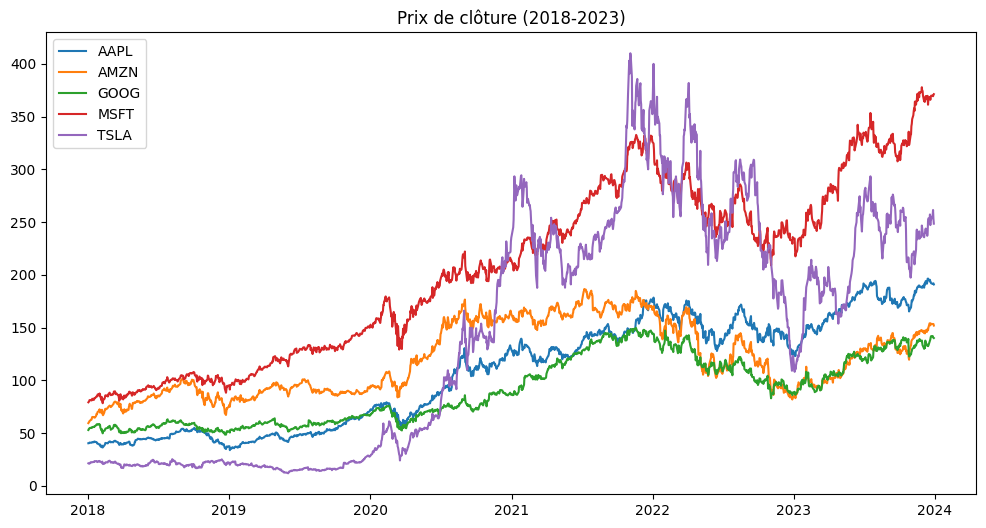

In [3]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt

# Tickeurs
tickers = ["AAPL", "MSFT", "GOOG", "AMZN", "TSLA"]

# Télécharger les données (prix de clôture ajustés par défaut)
raw_data = yf.download(tickers, start="2018-01-01", end="2023-12-31")
data = raw_data["Close"]

# Afficher les 5 premières lignes
print(data.head())

# Visualiser l’évolution des prix
plt.figure(figsize=(12,6))
for col in data.columns:
    plt.plot(data.index, data[col], label=col)

plt.title("Prix de clôture (2018-2023)")
plt.legend()
plt.show()


Ticker          AAPL      AMZN      GOOG      MSFT      TSLA
Date                                                        
2018-01-03 -0.000174  0.012694  0.016280  0.004643 -0.010286
2018-01-04  0.004634  0.004466  0.003615  0.008763 -0.008325
2018-01-05  0.011321  0.016033  0.014466  0.012322  0.006210
2018-01-08 -0.003721  0.014322  0.004264  0.001020  0.060755
2018-01-09 -0.000115  0.004665 -0.000615 -0.000680 -0.008118


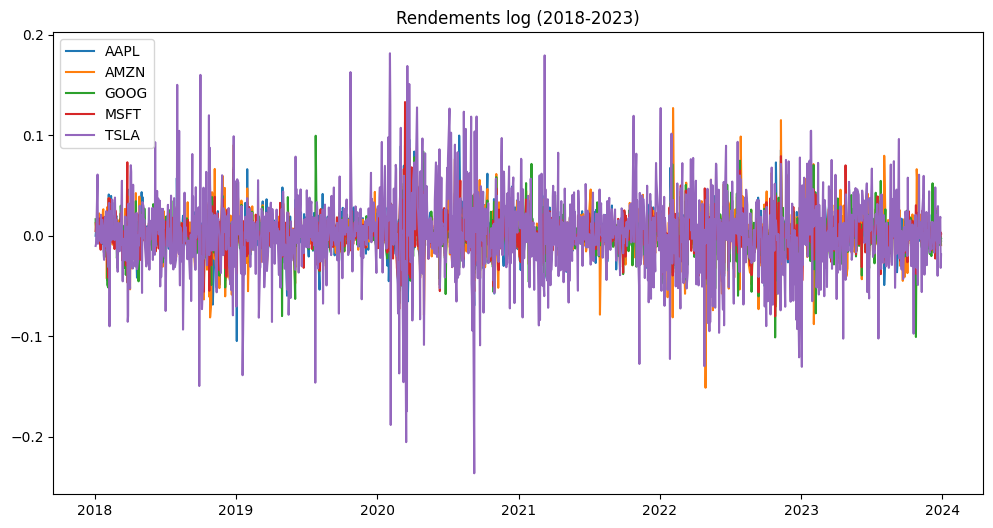

In [5]:
import numpy as np

# Rendements simples
returns = data.pct_change().dropna()

# Rendements log
log_returns = np.log(data / data.shift(1)).dropna()

# Afficher les 5 premières lignes
print(log_returns.head())

# Visualiser les rendements log
plt.figure(figsize=(12,6))
for col in log_returns.columns:
    plt.plot(log_returns.index, log_returns[col], label=col)

plt.title("Rendements log (2018-2023)")
plt.legend()
plt.show()


In [6]:
# --- A) Deux manières équivalentes de calculer le score momentum 126 jours ---

returns = data.pct_change()

# A1) Par produit de rendements (fenêtre rolling)
mom_prod = (1 + returns).rolling(window=126).apply(np.prod, raw=True) - 1

# A2) Par ratio de prix (équivalent, souvent plus simple/robuste)
mom_ratio = data / data.shift(126) - 1

# On utilisera mom = mom_ratio par simplicité
mom = mom_ratio

In [7]:
# Perf sur 252 jours en excluant les 21 derniers jours: P_{t-21}/P_{t-252} - 1
mom_12_1 = data.shift(21) / data.shift(252) - 1

In [8]:
def cross_sectional_signal(score_df, top_q=0.2, bottom_q=0.2):
    """
    Retourne un DataFrame de signaux dans {-1, 0, +1} :
    +1 pour les winners (top quantile), -1 pour les losers (bottom quantile), 0 sinon.
    """
    # Rangs percentiles par ligne (date)
    ranks = score_df.rank(axis=1, pct=True, method='first')

    long_mask = ranks >= (1 - top_q)
    short_mask = ranks <= bottom_q

    signal = pd.DataFrame(0, index=score_df.index, columns=score_df.columns, dtype=int)
    signal[long_mask] = 1
    signal[short_mask] = -1
    return signal

signal = cross_sectional_signal(mom, top_q=0.2, bottom_q=0.2)
signal.tail()


Ticker,AAPL,AMZN,GOOG,MSFT,TSLA
Date,,,,,
2023-12-22,0,1,1,0,-1
2023-12-26,0,1,1,0,-1
2023-12-27,0,1,1,0,-1
2023-12-28,0,1,1,0,-1
2023-12-29,0,1,1,0,-1


In [11]:
# Dates de rebalancement: dernier jour ouvré de chaque mois
rebalance_dates = mom.resample('BM').last().index

signal_m = signal.loc[rebalance_dates]
# On "forward-fill" pour tenir la position entre deux rebalancements
signal_m = signal_m.reindex(signal.index).ffill()

C:\Users\franc\AppData\Local\Temp\ipykernel_32648\1278359007.py:2: FutureWarning: 'BM' is deprecated and will be removed in a future version, please use 'BME' instead.
  rebalance_dates = mom.resample('BM').last().index


KeyError: "[Timestamp('2018-03-30 00:00:00'), Timestamp('2021-05-31 00:00:00')] not in index"

In [10]:
# PnL journalier égal-pondéré : moyenne des (signal * returns)
# (on aligne returns sur le même index)
common_index = signal_m.index.intersection(returns.index)
sig = signal_m.loc[common_index]
rets = returns.loc[common_index]

# Equal-weight: moyenne sur les colonnes non nulles
weights = sig.replace(0, np.nan)
weights = weights.div(weights.abs().sum(axis=1), axis=0)  # normalise somme des poids absolus à 1
weights = weights.fillna(0)

# PnL journalier
pnl = (weights * rets).sum(axis=1)

# Courbe de valeur cumulée
equity_curve = (1 + pnl).cumprod()

# Petit affichage
import matplotlib.pyplot as plt
plt.figure(figsize=(12,6))
plt.plot(equity_curve.index, equity_curve.values)
plt.title("Momentum L/S égal-pondéré — Valeur cumulée (sans coûts)")
plt.show()

# Quelques métriques brèves
def sharpe(serie, freq=252):
    mu = serie.mean() * freq
    sigma = serie.std(ddof=1) * np.sqrt(freq)
    return mu / sigma if sigma != 0 else np.nan

def max_drawdown(cum_curve):
    roll_max = cum_curve.cummax()
    dd = cum_curve / roll_max - 1.0
    return dd.min()

print("Sharpe (ann.):", round(sharpe(pnl), 2))
print("Max Drawdown :", round(max_drawdown(equity_curve), 2))


NameError: name 'signal_m' is not defined